 Predicting The Occurrence of Exercised Induced-Angina by Analysis of Blood Pressure and Maximum Heart Rate

Introduction: 

Background Information: 


Methods & Results: 

In [2]:
library(tidyverse)
library(tidymodels)


url<- "https://raw.githubusercontent.com/elaines6/dsci-100-group-project/main/processed.cleveland.data"
heart_raw_data <- read_csv(url, col_names = c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_bs", "rest_ecg", "max_rate",
                                             "exercise_induced_angina", "ST_depression", "slope_peak_exercise", "major_vessels", "thal", "diagnosis_heart_disease"))
heart_data_tidy <- heart_raw_data |>
    mutate(sex = as_factor(sex), chest_pain_type = as_factor(chest_pain_type), exercise_induced_angina = as_factor(exercise_induced_angina)) |>
    mutate(sex = fct_recode(sex, "Female" = "0", "Male" = "1")) |>
    mutate(exercise_induced_angina = fct_recode(exercise_induced_angina, "Yes" = "1", "No" = "0")) |>
    mutate(chest_pain_type = fct_recode(chest_pain_type, "Typical angina" = "1", "Atypical angina" = "2", "Non-anginal pain" = "3", "Asymptomatic" = "4")) |>
    filter(age != "?" & sex != "?"& chest_pain_type != "?"& resting_bp != "?"& max_rate!= "?"& exercise_induced_angina != "?")

unscaled_heart_data <- heart_data_tidy |>
    select(resting_bp, max_rate, exercise_induced_angina) |>
    mutate(resting_bp = as.integer(resting_bp), max_rate = as.integer(max_rate))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

age,sex,chest_pain_type,resting_bp,chol,fasting_bs,rest_ecg,max_rate,exercise_induced_angina,ST_depression,slope_peak_exercise,major_vessels,thal,diagnosis_heart_disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,Male,Typical angina,145,233,1,2,150,No,2.3,3,0.0,6.0,0
67,Male,Asymptomatic,160,286,0,2,108,Yes,1.5,2,3.0,3.0,2
67,Male,Asymptomatic,120,229,0,2,129,Yes,2.6,2,2.0,7.0,1
37,Male,Non-anginal pain,130,250,0,0,187,No,3.5,3,0.0,3.0,0
41,Female,Atypical angina,130,204,0,2,172,No,1.4,1,0.0,3.0,0
56,Male,Atypical angina,120,236,0,0,178,No,0.8,1,0.0,3.0,0
62,Female,Asymptomatic,140,268,0,2,160,No,3.6,3,2.0,3.0,3
57,Female,Asymptomatic,120,354,0,0,163,Yes,0.6,1,0.0,3.0,0
63,Male,Asymptomatic,130,254,0,2,147,No,1.4,2,1.0,7.0,2


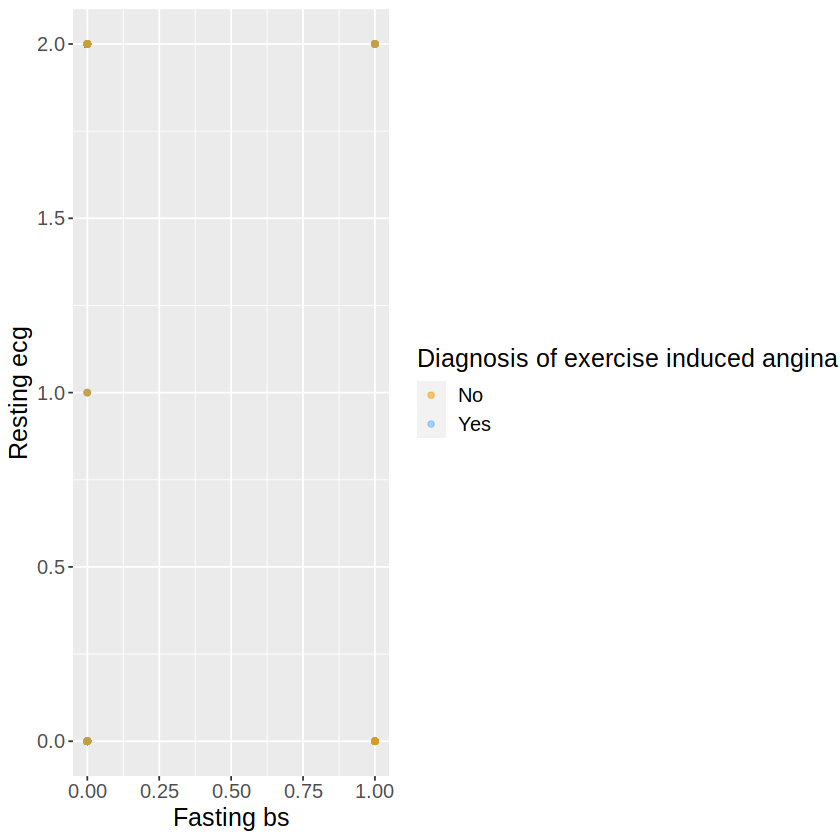

In [8]:
heart_data_tidy


heart_plot_one <- heart_data_tidy|>
    ggplot(aes(x= fasting_bs, y= rest_ecg, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Fasting bs", 
         y= "Resting ecg",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_one

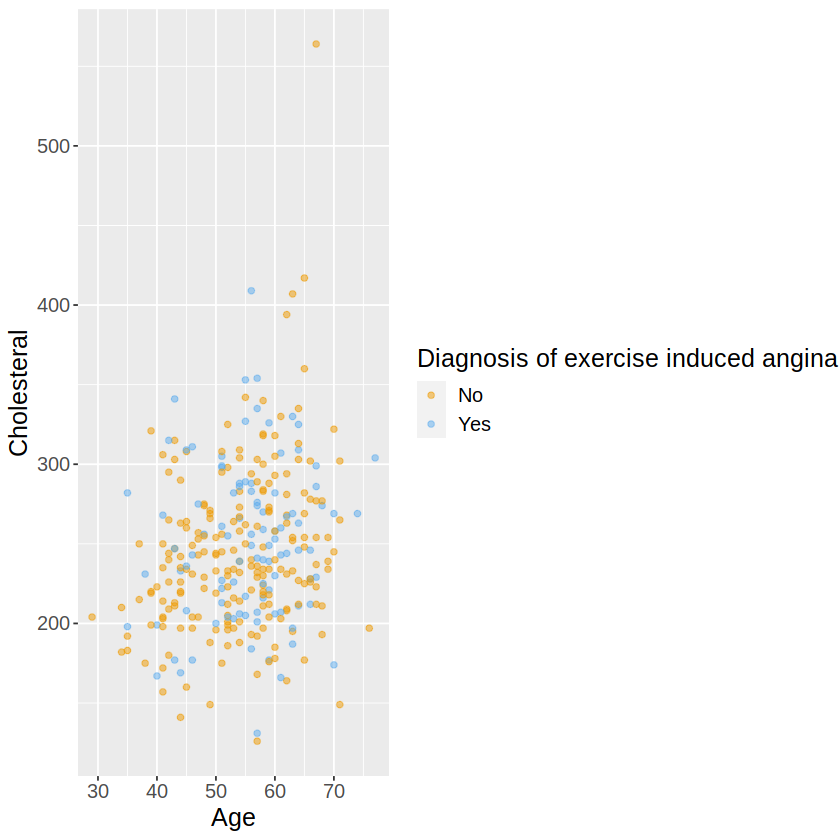

In [18]:
heart_plot_two <- heart_data_tidy|>
    ggplot(aes(x= age, y= chol, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Age", 
         y= "Cholesteral",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_two

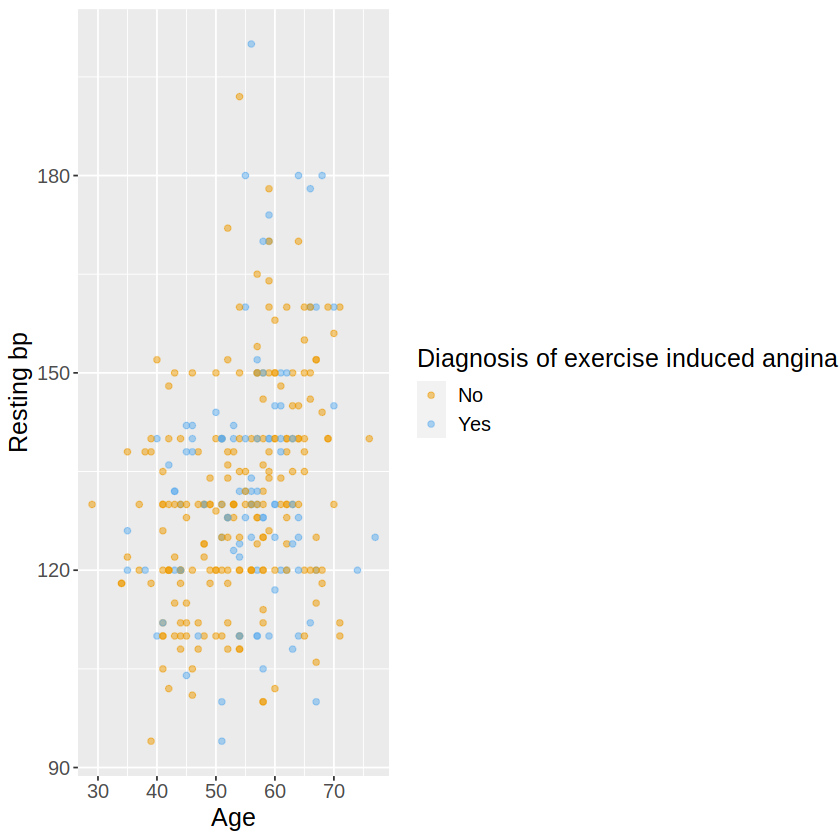

In [19]:
heart_plot_three <- heart_data_tidy|>
    ggplot(aes(x= age, y= resting_bp, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Age", 
         y= "Resting bp",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_three

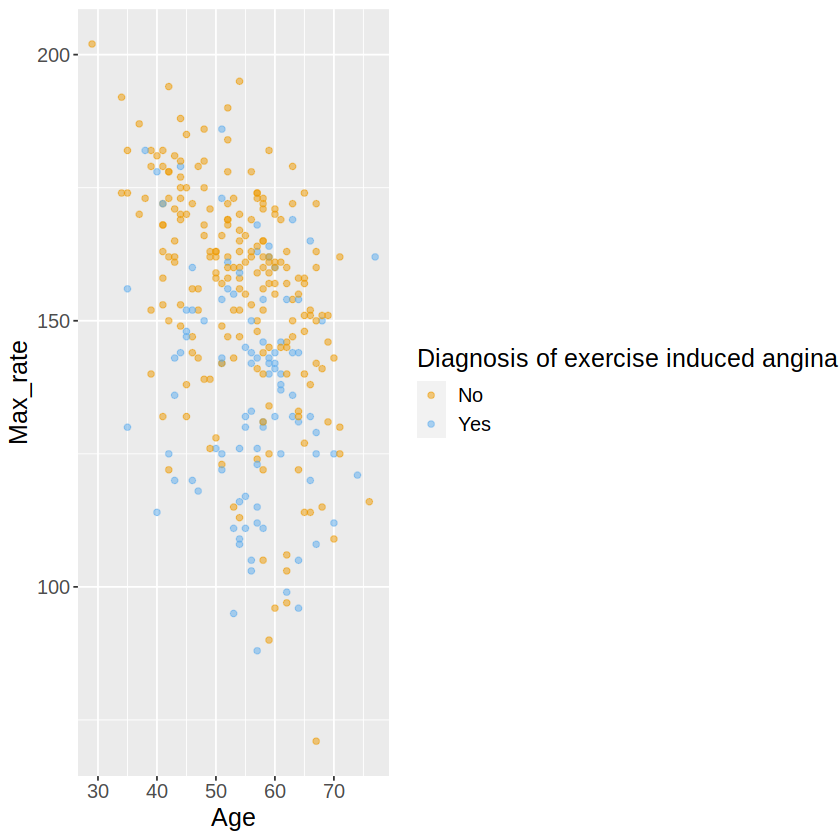

In [20]:
heart_plot_four <- heart_data_tidy|>
    ggplot(aes(x= age, y= max_rate, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Age", 
         y= "Max Rate",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_four

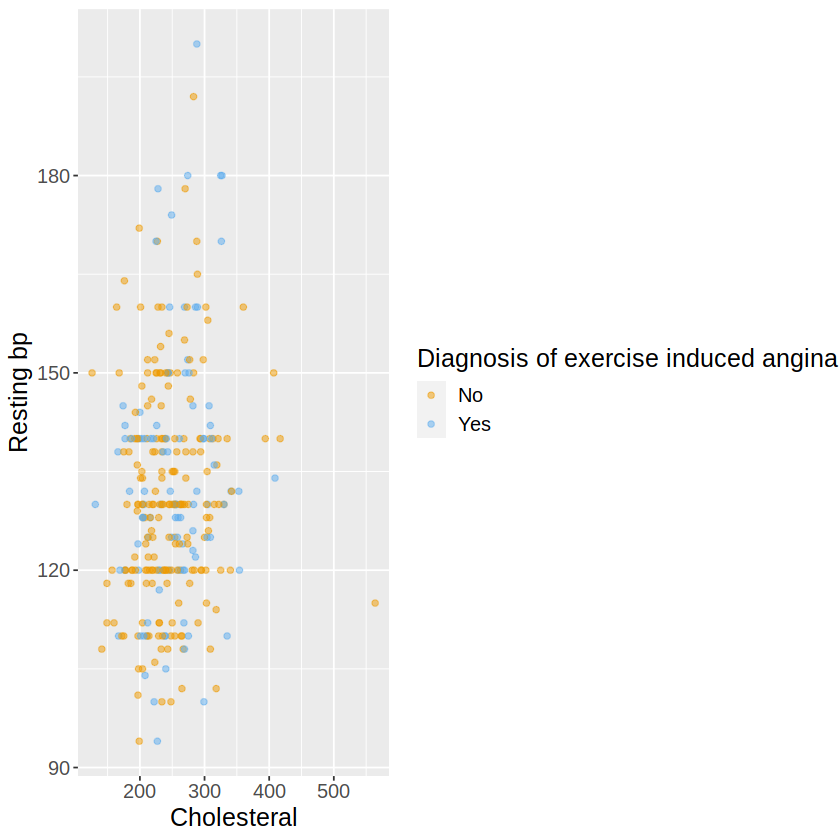

In [21]:
heart_plot_five <- heart_data_tidy|>
    ggplot(aes(x= chol, y= resting_bp, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Cholesteral", 
         y= "Resting bp",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_five

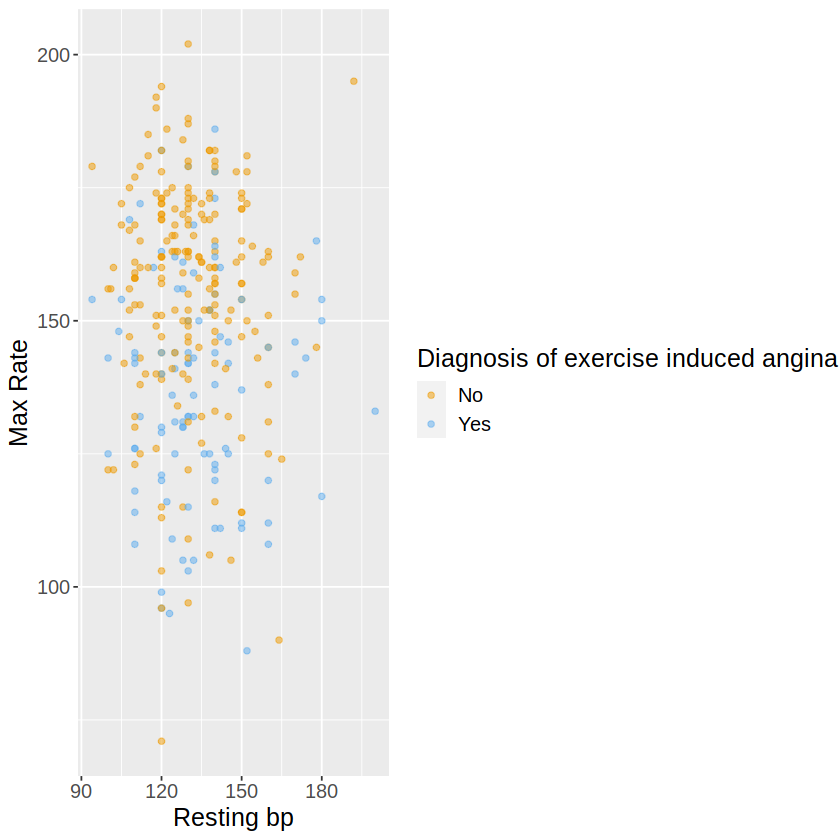

In [22]:
heart_plot_six <- heart_data_tidy|>
    ggplot(aes(x= resting_bp, y= max_rate, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Resting bp", 
         y= "Max Rate",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_six

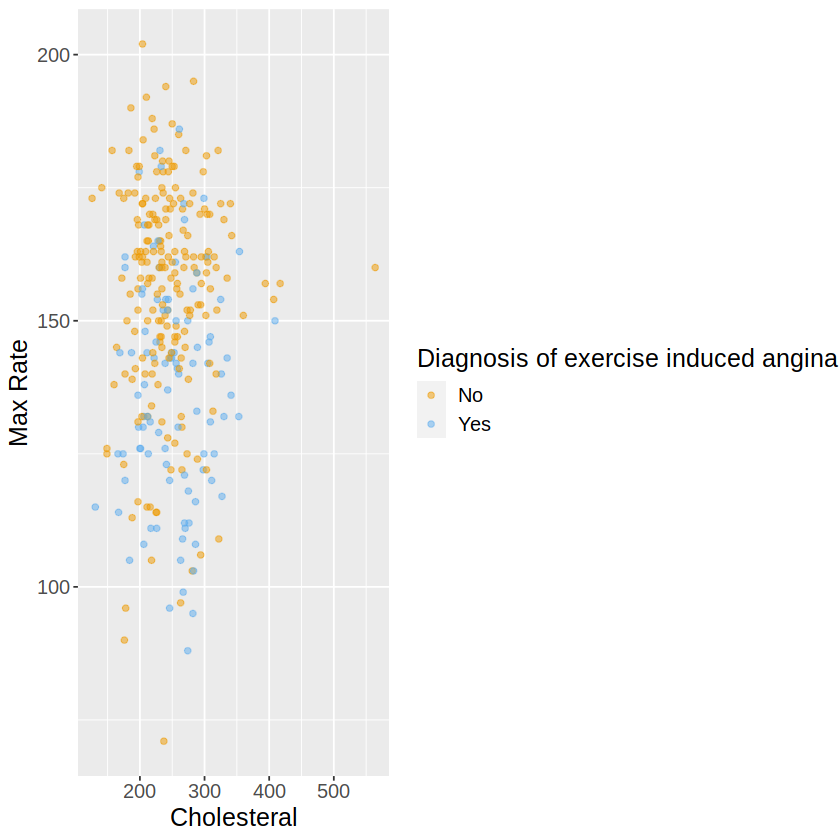

In [23]:
heart_plot_seven <- heart_data_tidy|>
    ggplot(aes(x= chol, y= max_rate, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Cholesteral", 
         y= "Max Rate",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_seven

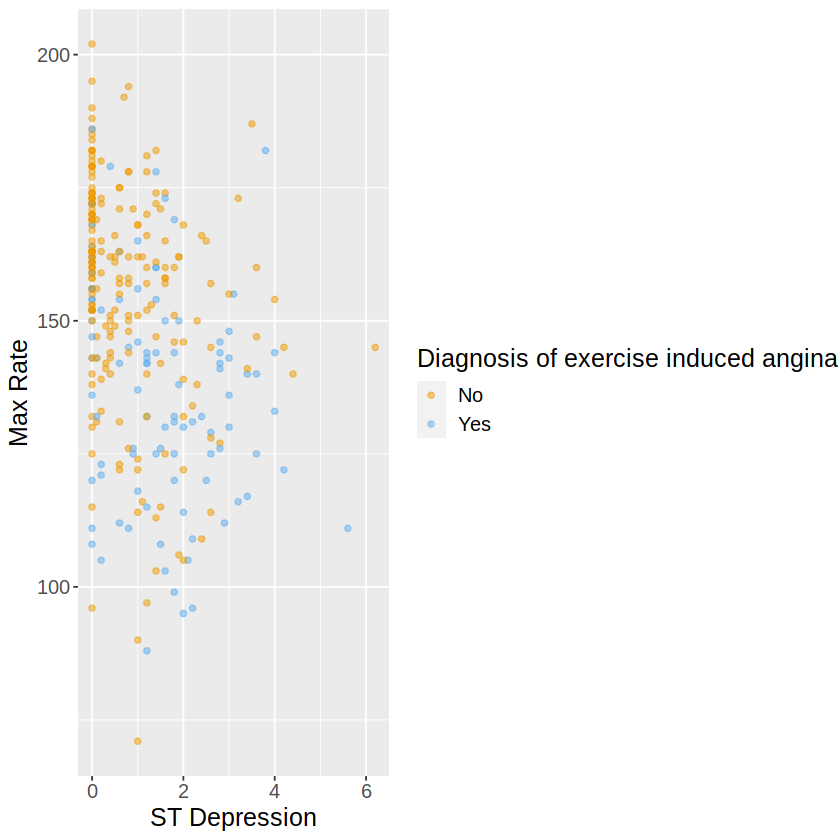

In [24]:
heart_plot_eight <- heart_data_tidy|>
    ggplot(aes(x= ST_depression, y= max_rate, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "ST Depression", 
         y= "Max Rate",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_eight

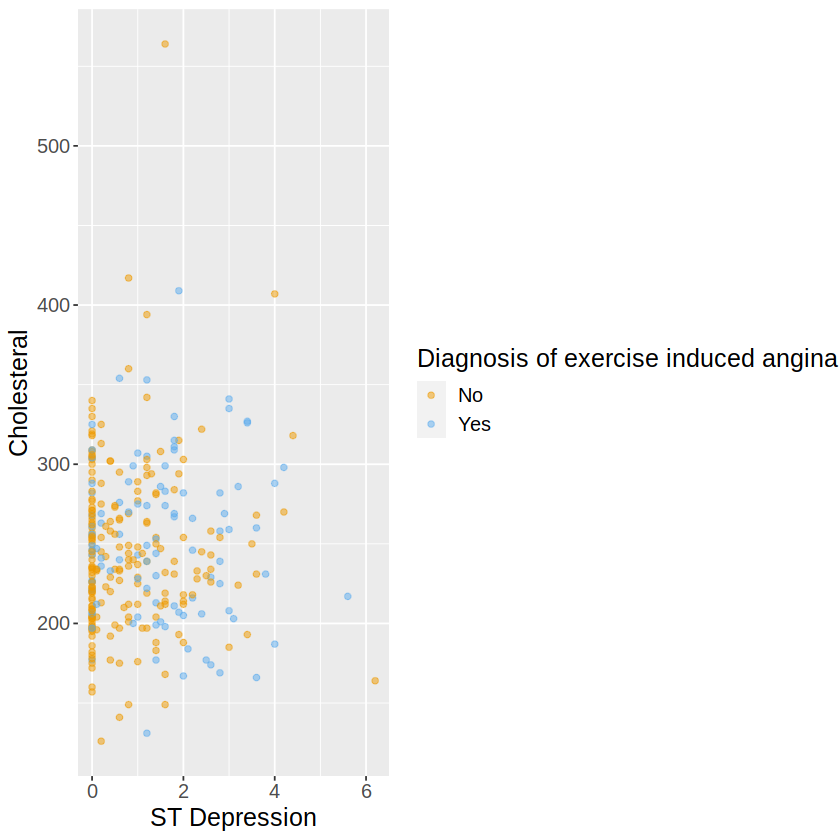

In [26]:
heart_plot_nine <- heart_data_tidy|>
    ggplot(aes(x= ST_depression, y= chol, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "ST Depression", 
         y= "Cholesteral",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_nine

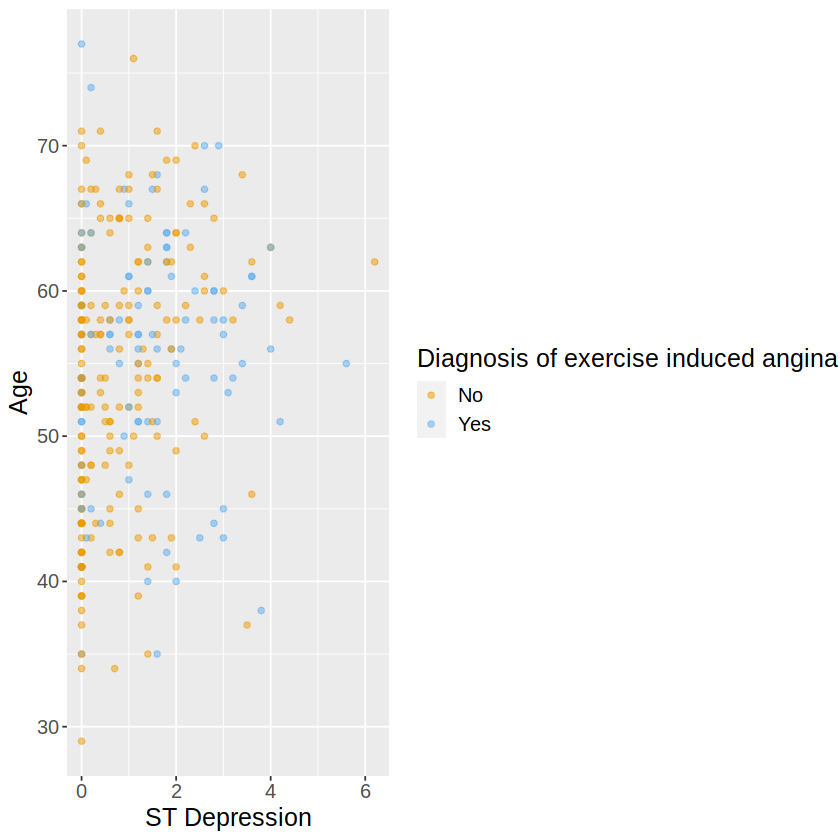

In [27]:
heart_plot_ten <- heart_data_tidy|>
    ggplot(aes(x= ST_depression, y= age, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "ST Depression", 
         y= "Age",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_ten